# Sweet Lift Taxi

## 1. Contenido

* [1 Contenido](#content)
* [2 Introducción](#content)
* [3 Preparación](#prep)
    * [3.1 Cargar Librerias](#library)
    * [3.2 Cargar Datos](#datos)
    * [3.3 Exploración](#exp) 
    * [3.4 Remuestreo](#remuetreo)    
* [4 Análisis](#analisis) 
    * [4.1 Tendencias y estacionalidad](#tye)
* [5 Formación](#form)
    * [5.1 Diferencias de series temporales](#dif)
    * [5.2 Creación de características](#carac)
    * [5.3 Segmentación de datos](#seg)
    * [5.4 Prueba de cordura](#pc)
    * [5.5 Regresión lineal](#rl)
    * [5.6 Random forest](#rf)    
    * [5.7 XGBoost](#xgb)
    * [5.8 LightGBM](#lgbm)
* [6 Prueba](#test)

## 2. Introducción

La compañía Sweet Lift Taxi ha recopilado datos históricos sobre pedidos de taxis en los aeropuertos. Para atraer a más conductores durante las horas pico, necesitamos predecir la cantidad de pedidos de taxis para la próxima hora. Construiremos un modelo para dicha predicción.

La métrica RECM en el conjunto de prueba no debe ser superior a 48.

## 3. Preparación

### 3.1 Cargar Librerias

Se procede a cargar las librerías que se utilizaran en el proyecto.

In [1]:
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
import lightgbm as lgbm
from sklearn.ensemble import RandomForestRegressor

from sklearn.neural_network import MLPRegressor

### 3.2 Cargar datos

Se procede a cargar los datos.

In [2]:
data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])

### 3.3 Exploración

A continuación, procederemos a realizar un análisis sobre los datos entregados por Sweet Lift Taxi.

In [3]:
data.index.is_monotonic

True

Podemos confirmar que los datos se encuentran ordenados por fecha.

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [5]:
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


Observamos que los datos se encuentran con las fechas como índices y el número de ordenes realizadas en esa fecha como única columna, con un total de 26496 datos.

### 3.4. Remuestreo

Procederemos a realizar el remuestreo de los datos por una hora.

In [6]:
data = data.resample('1H').sum()

Continuaremos graficando la serie temporal tal cual como se encuentra en este momento.

<AxesSubplot:xlabel='datetime'>

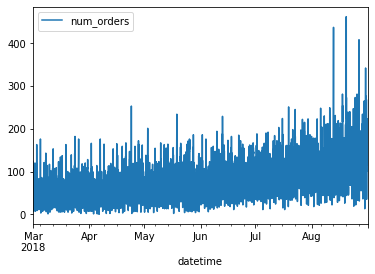

In [7]:
data.plot()

Al observar el grafico no podemos apreciar con claridad tendencias o patrones debido al cumulo de datos que este presenta, por lo cual no podemos obtener mayor información del mismo. Por lo anterior es que en la siguiente sección continuaremos analizando el gráfico por partes.

## 4. Análisis

### 4.1. Tendencias y estacionalidad

Comenzaremos el análisis de los datos elaborando gráficos de tendencia y estacionalidad para comprender de mejor manera los mismos.

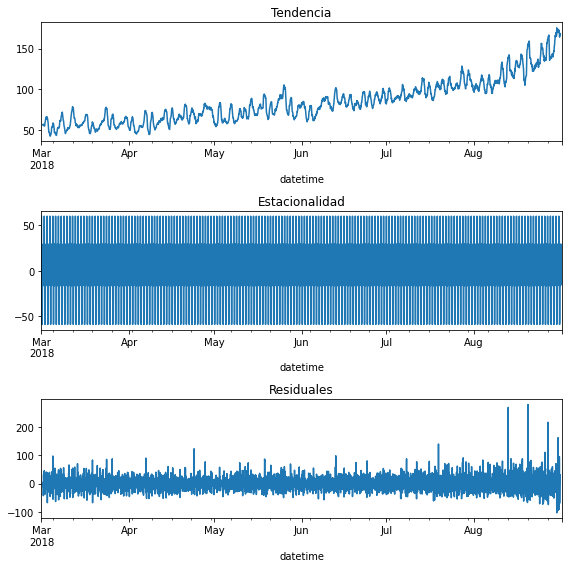

In [8]:
decomposed = seasonal_decompose(data)

plt.figure(figsize=(8, 8))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Tendencia')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Estacionalidad')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuales')
plt.tight_layout()

En el grafico de tendencia podemos apreciar claramente que a través de los 6 meses que recopilan los datos existe una tendencia alcista en el número de pedidos, lo que se traduce en un alza sostenida de los pedidos de taxis a través del tiempo. En el caso de la estacionalidad, debido a que los datos se encuentran remuestrados por hora, no somos capaces de observar algún patrón al existir demasiados datos agrupados. Con respecto a los residuales, al no poder explicarse por los dos gráficos anteriores y ser básicamente solo ruido, no se les analizara en mayor detalle.

Por lo anterior procederemos a realizar otro grafico de estacionalidad, pero solo con datos correspondientes a 3 días. 

Text(0.5, 1.0, 'Estacionalidad')

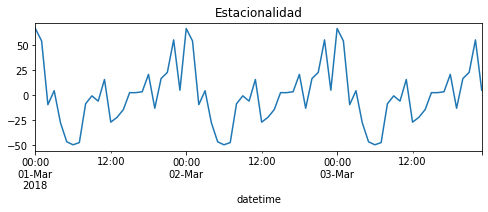

In [9]:
decomposed_seas = seasonal_decompose(data['2018-03-01':'2018-03-03'])

plt.figure(figsize=(8, 8))
plt.subplot(312)
decomposed_seas.seasonal.plot(ax=plt.gca())
plt.title('Estacionalidad')

Al observar el grafico de estacionalidad delimitado a tres días, podemos apreciar claramente que existe un patrón cíclico diario que se repite. Podemos notar que el peak máximo de pedidos de taxis se da alrededor de las 12 de la noche, estos descienden constantemente hasta llegar a su mínimo alrededor de las 3 de la mañana, posteriormente vuelven a subir existiendo un nuevo peak, menor que el de las 12 de la noche, alrededor de las 11am para descender hasta el mediodía y luego volver a aumentar con alzas y bajas hasta llegar nuevamente al peak máximo de las 12 noches.

## 5. Formación

### 5.1. Diferencias de series temporales

Comenzaremos el entrenamiento de los modelos comprobando si la serie temporal es una serie estacionaria.

<AxesSubplot:xlabel='datetime'>

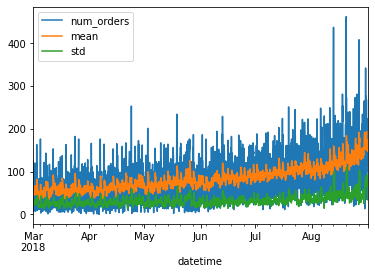

In [10]:
data['mean'] = data['num_orders'].rolling(15).mean()
data['std'] = data['num_orders'].rolling(15).std()
data.plot()

Como podemos observar en el gráfico, por un lado la desviación estándar no varía en función del tiempo lo cual es un indicador de que nos encontramos con una serie estacionaria, por otra parte la media tiene una pequeña variación al alza en función del tiempo por lo que aunque la serie no sea completamente estacionaria si es lo suficiente como para continuar el proyecto sin intervenirla.  

In [11]:
data = data.drop(['mean','std'], axis=1)

### 5.2. Creación de características

Continuaremos creando las características para el horizonte de pronostico.

In [12]:
def make_features(data, max_lag, rolling_mean_size):
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour

    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = (data['num_orders'].shift().rolling(rolling_mean_size).mean())

In [13]:
make_features(data, 4, 15)

In [14]:
data = data.dropna()

### 5.3. Segmentación de datos

Procedemos con la segmentación de los datos, crearemos tres segmentos, entrenamiento, validación y testeo en una proporción de 8:1:1.

In [15]:
train, valid_test = train_test_split(data, shuffle=False, test_size=0.2)
valid, test = train_test_split(valid_test, shuffle=False, test_size=0.5)

print(train.index.min(), train.index.max())
print(valid.index.min(), valid.index.max())
print(test.index.min(), test.index.max())

2018-03-01 15:00:00 2018-07-26 06:00:00
2018-07-26 07:00:00 2018-08-13 14:00:00
2018-08-13 15:00:00 2018-08-31 23:00:00


In [16]:
features_train = train.drop(['num_orders'], axis=1)
target_train = train['num_orders']
features_valid = valid.drop(['num_orders'], axis=1)
target_valid = valid['num_orders']
features_test = test.drop(['num_orders'], axis=1)
target_test = test['num_orders']

### 5.4. Prueba de cordura

Crearemos un modelo dummy para comparar con el resto de los modelos entrenados.

In [17]:
print('Pedidos medios de taxis diarios:', valid['num_orders'].median())
pred_previous = valid.shift()
pred_previous.iloc[0] = train.iloc[-1]
print('RECM:', np.sqrt(mean_squared_error(valid['num_orders'],pred_previous['num_orders'])))

Pedidos medios de taxis diarios: 105.0
RECM: 47.210385028566066


### 5.5. Regresión lineal

Entrenaremos un modelo en base a la regresión lineal.

In [18]:
model = LinearRegression()
model.fit(features_train, target_train)
pred_test = model.predict(features_valid)
print("RECM:", np.sqrt(mean_squared_error(target_valid, pred_test)))

RECM: 42.108982020508556


### 5.6. Random forest

In [19]:
best_model = None
best_result = 10000
best_est = 0
best_depth = 0
best_split = 0
for est in range(10, 90, 10):
    for depth in range (1, 8):
        for split in range(2,7):
            model_rf = RandomForestRegressor(random_state=12345, n_estimators=est,  max_depth=depth, min_samples_split=split)
            model_rf.fit(features_train, target_train) 
            predictions_rf = model_rf.predict(features_valid) 
            result_rf = np.sqrt(mean_squared_error(target_valid, predictions_rf))
            if result_rf < best_result:
                best_model = model_rf
                best_result = result_rf
                best_est = est
                best_depth = depth
                best_split = split
print("mejor RECM", best_result, "n_estimators:", best_est, "best_depth:", best_depth, "best_min_sample_split:", best_split)

mejor RECM 34.857155410198736 n_estimators: 80 best_depth: 7 best_min_sample_split: 5


### 5.7. XGBoost

Entrenaremos un modelo en base a XGBoost.

In [20]:
xgb_model = xgb.XGBRegressor() 
xgb_params = {'max_depth': [2,3,4], 
              'eta': [0.7,0.8], 
              'min_child_weight': [6,7,8], 
               'subsample': [0.7,0.8]}

In [21]:
clf = GridSearchCV(estimator=xgb_model, param_grid =xgb_params, scoring='neg_mean_squared_error',  n_jobs=-1)
clf.fit(features_train, target_train)
clf.best_params_

{'eta': 0.7, 'max_depth': 2, 'min_child_weight': 8, 'subsample': 0.8}

In [22]:
xgb_model = xgb.XGBRegressor(eta=0.7, max_depth=2, random_state=12345, colsample_bytree=0.6, min_child_weight=8, subsample=0.8)
xgb_model.fit(features_train, target_train, eval_set=[(features_valid, target_valid)]) 
preds_xgb_model = xgb_model.predict(features_valid)
print("RECM:", np.sqrt(mean_squared_error(target_valid, preds_xgb_model)))

[0]	validation_0-rmse:68.89155
[1]	validation_0-rmse:53.58696
[2]	validation_0-rmse:47.46763
[3]	validation_0-rmse:45.08197
[4]	validation_0-rmse:42.08619
[5]	validation_0-rmse:41.12695
[6]	validation_0-rmse:40.28019
[7]	validation_0-rmse:40.55709
[8]	validation_0-rmse:39.80264
[9]	validation_0-rmse:39.70629
[10]	validation_0-rmse:39.63177
[11]	validation_0-rmse:38.42016
[12]	validation_0-rmse:37.42312
[13]	validation_0-rmse:37.23650
[14]	validation_0-rmse:36.83711
[15]	validation_0-rmse:36.27561
[16]	validation_0-rmse:35.70149
[17]	validation_0-rmse:35.95283
[18]	validation_0-rmse:35.78412
[19]	validation_0-rmse:34.87384
[20]	validation_0-rmse:34.53329
[21]	validation_0-rmse:34.67147
[22]	validation_0-rmse:34.96271
[23]	validation_0-rmse:35.17084
[24]	validation_0-rmse:35.04250
[25]	validation_0-rmse:34.63747
[26]	validation_0-rmse:34.68523
[27]	validation_0-rmse:34.46412
[28]	validation_0-rmse:34.53212
[29]	validation_0-rmse:34.60327
[30]	validation_0-rmse:34.13627
[31]	validation_0-

### 5.8. LightGBM

Entrenaremos un modelo en base a lightGBM.

In [23]:
LGB = lgbm.LGBMRegressor()

In [24]:
parameters = {'max_depth' : np.linspace(1, 7, 5).astype("int"),
              'num_leaves' : [2, 3, 4, 5],
              'learning_rate' : [0.01, 0.05, 0.08, 0.1, 0.4],
              'objective' : ['root_mean_squared_error']}

In [25]:
Grid_LGB = GridSearchCV(estimator=lgbm.LGBMRegressor(random_state=12345,force_row_wise='true'), param_grid = parameters, scoring="neg_mean_squared_error", n_jobs=-1)
Grid_LGB.fit(features_train, target_train)
Grid_LGB.best_params_

{'learning_rate': 0.4,
 'max_depth': 4,
 'num_leaves': 4,
 'objective': 'root_mean_squared_error'}

In [26]:
lgb_model = lgbm.LGBMRegressor(boosting_type='gbdt',
    objective='root_mean_squared_error',
    max_depth=4,
    num_leaves=4,
    learning_rate=0.4,
    random_state=12345,
    min_child_samples=8)
lgb_model.fit(features_train, target_train, eval_set=[(features_valid, target_valid)]) 
preds_lgb_model = lgb_model.predict(features_valid)
print("RECM:", np.sqrt(mean_squared_error(target_valid, preds_lgb_model)))

[1]	valid_0's rmse: 54.1759
[2]	valid_0's rmse: 50.8204
[3]	valid_0's rmse: 47.4027
[4]	valid_0's rmse: 43.5046
[5]	valid_0's rmse: 42.8395
[6]	valid_0's rmse: 41.0351
[7]	valid_0's rmse: 39.2437
[8]	valid_0's rmse: 38.8851
[9]	valid_0's rmse: 38.5085
[10]	valid_0's rmse: 36.9125
[11]	valid_0's rmse: 36.5815
[12]	valid_0's rmse: 36.0574
[13]	valid_0's rmse: 36.0519
[14]	valid_0's rmse: 35.0408
[15]	valid_0's rmse: 35.1752
[16]	valid_0's rmse: 35.0336
[17]	valid_0's rmse: 34.8786
[18]	valid_0's rmse: 34.9154
[19]	valid_0's rmse: 34.8768
[20]	valid_0's rmse: 34.6157
[21]	valid_0's rmse: 34.4818
[22]	valid_0's rmse: 34.3302
[23]	valid_0's rmse: 34.42
[24]	valid_0's rmse: 34.3289
[25]	valid_0's rmse: 34.3559
[26]	valid_0's rmse: 34.2711
[27]	valid_0's rmse: 34.1449
[28]	valid_0's rmse: 34.2415
[29]	valid_0's rmse: 34.1981
[30]	valid_0's rmse: 33.9579
[31]	valid_0's rmse: 33.8828
[32]	valid_0's rmse: 33.7993
[33]	valid_0's rmse: 34.0244
[34]	valid_0's rmse: 33.9904
[35]	valid_0's rmse: 33.6

## 6. Prueba

Los modelos anteriormente entrenados obtuvieron un mejor resultado de RECM que nuestro modelo dummy, el que obtuvo el mejor resultado de todos es el basado en XGBoost por lo que utilizaremos este último para realizar una nueva prueva de cordura y la prueba final con el conjunto de prueba.

In [27]:
pred_previous = test.shift()
pred_previous.iloc[0] = valid.iloc[-1]
print('RECM Modelo Dummy:', np.sqrt(mean_squared_error(test['num_orders'],pred_previous['num_orders'])))

RECM Modelo Dummy: 58.91761802963282


In [28]:
preds_xgb_model = xgb_model.predict(features_test)
print("RECM:", np.sqrt(mean_squared_error(target_test, preds_xgb_model)))

RECM: 47.99677177507551


Nuestro modelo basado en XGBoost obtuvo un RECM de 47.99 con la muestra de prueba, lo cual es menor que lo obtenido por nuestro modelo dummy y a su vez menor al mínimo exigido de un RECM igual a 48. En base a lo anterior podemos concluir que nuestro modelo cumple con los requerimientos exigidos por el mandante con respecto a que este pueda predecir la cantidad de pedidos de taxis para la próxima hora.  